In [7]:
import os
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
from kooplearn.datasets import LogisticMap
logistic = LogisticMap(N = 20, rng_seed=0)

In [8]:
#List and unpickle all files in "results/"
reports = []
for file in os.listdir("results/"):
    if file.endswith(".pkl"):
        with open("results/"+file, "rb") as f:
            reports.append(pickle.load(f))

def get_series(report, key):
    report = deepcopy(report)
    model_name = report.pop("name")
    feature_dims = []
    series = []
    for k, v in report.items():
        feature_dims.append(int(k.split('_')[0]))
        series.append(v.get(key, 0))
    _perm = np.argsort(feature_dims)
    feature_dims = np.array(feature_dims)[_perm]
    series = np.array(series)[_perm]
    return feature_dims, series, model_name

def get_eigs(report):
    report = deepcopy(report)
    model_name = report.pop("name")
    feature_dims = []
    eigs = []
    for k, v in report.items():
        feature_dims.append(int(k.split('_')[0]))
        eigs.append(v['estimator-eigenvalues'])
    feature_dims = np.arange(len(report)) + 2
    return feature_dims, eigs, model_name

def tabular_report(reports):
    
    table_records = {}
    for r in reports:
        r = deepcopy(r)
        model_name = r.pop("name")
        features = sorted([int(k.split('_')[0]) for k in r.keys()])
        for num_features in features:
            
        print(f"{model_name}: {features}")
    table_records = []
    for report in reports:
        table_records.append(timing_report(report))

def tabulate_model_report(model_name, fixed_feature_dim_report):
    r = deepcopy(fixed_feature_dim_report)
    optgap = f"${r['optimality-gap']:0.3f}"
    if 'optimality-gap_std' in r:
        optgap += f"\pm{r['optimality-gap_std']:0.3f}$"
    else:
        optgap += "$"
    feasgap = f"${r['feasibility-gap']:0.3f}"
    if 'feasibility-gap_std' in r:
        feasgap += f"\pm{r['feasibility-gap_std']:0.3f}$"
    else:
        feasgap += "$"
    specerr = f"${r['hausdorff-distance']:0.3f}"
    if 'hausdorff-distance_std' in r:
        specerr += f"\pm{r['hausdorff-distance_std']:0.3f}$"
    else:
        specerr += "$"
    
    if 'time_per_epoch' in r:
        time_per_epoch = f"${r['time_per_epoch']:0.3f}"
        if 'time_per_epoch_std' in r:
            time_per_epoch += f"\pm{r['time_per_epoch_std']:0.3f}$"
        else:
            time_per_epoch += "$"
    else:
        time_per_epoch = '-'
    return model_name, optgap, feasgap, specerr, time_per_epoch

In [32]:
stacked_reports = {}
for r in reports:
    r = deepcopy(r)
    model_name = r.pop("name")
    for k, v in r.items():
        if k not in stacked_reports:
            stacked_reports[k] = []
        stacked_reports[k].append(tabulate_model_report(model_name, v))

In [35]:
from tabulate import tabulate
num_features = 4
key = f"{num_features}_features"

headers = [r"\textbf{Representation}", r"\textbf{Optimality Gap}", r"\textbf{Feasibility Gap}", r"Spectral Error", r"Time per epoch (s)"]
print(tabulate(stacked_reports[key], headers=headers, tablefmt="latex_raw", colalign=("right", "center", "center")))

\begin{tabular}{rccll}
\hline
   \textbf{Representation} &  \textbf{Optimality Gap}  &  \textbf{Feasibility Gap}  & Spectral Error   & Time per epoch (s)   \\
\hline
            DPNets-relaxed &      $1.479\pm0.142$      &      $0.114\pm0.053$       & $0.286\pm0.092$  & $0.062\pm0.001$      \\
                  VAMPNets &      $1.443\pm0.135$      &      $1.884\pm0.045$       & $0.281\pm0.068$  & $0.062\pm0.001$      \\
                   Cheby-T &          $1.821$          &          $1.026$           & $0.253$          & -                    \\
               NoiseKernel &          $2.576$          &          $0.998$           & $0.470$          & -                    \\
                    DPNets &      $1.434\pm0.126$      &      $0.097\pm0.054$       & $0.261\pm0.092$  & $0.064\pm0.001$      \\
\hline
\end{tabular}


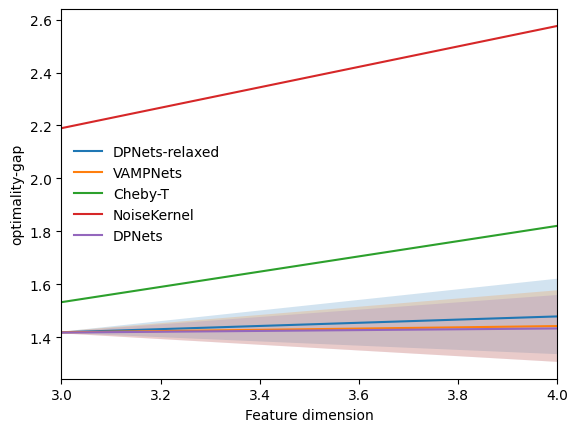

In [34]:
fig, ax = plt.subplots()
series = "optimality-gap"
for report in reports:
    x, y, model_name = get_series(report, series)
    _, dy, _ = get_series(report, series +"_std")
    ax.plot(x, y, label=model_name)
    ax.fill_between(x, y - dy, y + dy, alpha=0.2)
ax.set_xlabel("Feature dimension")
ax.set_ylabel(series)
ax.set_xmargin(0)
ax.legend(frameon=False)

In [17]:
def plot_eigs(reports, feature_dim):
    fig, ax = plt.subplots(figsize=(5, 5))  
    #Activate grid
    ax.grid(True, which='both')
    #Plot unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='k', lw=0.75)   
    for report in reports:
        feature_dims, eigs, model_name = get_eigs(report)
        feature_idx = np.where(feature_dims == feature_dim)[0][0]
        eigs = eigs[feature_idx]
        print(f"{model_name} eigenvalues: {eigs}")
        ax.scatter(eigs.real, eigs.imag, s = 10, label = model_name)
    ax.scatter(logistic.eig().real, logistic.eig().imag, marker='x', color='k', label = 'True eigenvalues')
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=3, fontsize=8)
    ax.set_aspect('equal')

IndexError: index 0 is out of bounds for axis 0 with size 0

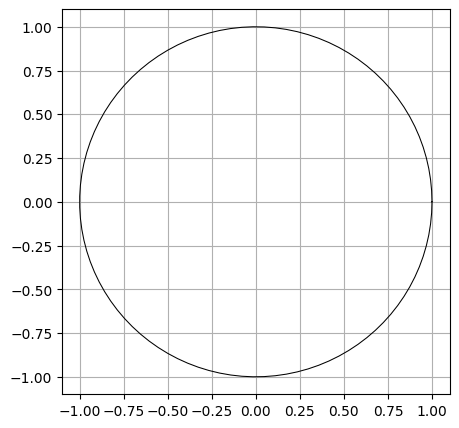

In [19]:
plot_eigs(reports, 4)